In [59]:
import pandas as pd
import textdistance
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
from itertools import combinations
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import seaborn as sns


#    Experiments:

#    1 - no prompt typewriter
#    2 - no prompt all
#    3 - prompt typewriter
#    4 - prompt all
###

In [2]:
#### Takes in a dataset of repeated measures and does the stats on the selected columns
def statprint(df, keylist):
    #descriptive statistics
    print("C", "Mean", "Std")
    for k in keylist: 
        print(k, round(stats.tmean(df[k]),3), round(stats.tstd(df[k]),3))
    print("-----------")
    
    normalities = {}
    allnormal = True

    sets = []
    for k in keylist:
        sets.append(df[k])
    
    for k in keylist:
        normalities[k] = stats.normaltest(df[k]).pvalue
        if normalities[k] < 0.05:
            allnormal=False
        #print(stats.normaltest(testdf[k])) #normal p>0.05
    
    #anova or friedman?
    if allnormal:
        toprint = "ANOVA "
        stat = stats.f_oneway(*sets)
    else:
        toprint = "FRIEDMAN "
        stat = stats.friedmanchisquare(*sets)
        
    print(toprint+str(round(stat.statistic, 3)) + ", p="+str(round(stat.pvalue,3)))
    print("-----------")
    
    if stat.pvalue<0.05: # go to paired tests
    
        #paired sample tests
        
        combos = list(combinations(keylist, 2))
        padj = 0.05/len(combos)
        
        for combo in combos:
            if normalities[combo[0]]>0.05 and normalities[combo[1]]>0.05:
                stat = stats.ttest_rel(df[combo[0]],df[combo[1]])
                toprint = "T-test "
                toprint += "("+str(combo[0]) +", "+ str(combo[1]) + "): t="+ str(round(stat.statistic, 3)) + ", p="+str(round(stat.pvalue,3))
            else:
                stat = stats.wilcoxon(df[combo[0]],df[combo[1]], method='approx')
                toprint = "Wilcoxon "
                toprint += "("+str(combo[0]) +", "+ str(combo[1]) + "): Z="+ str(round(stat.zstatistic, 3)) + ", p="+str(round(stat.pvalue,3))
            
            
            
            if stat.pvalue<padj:
                toprint+=" *"
            print(toprint)
        
        print ("bf-adj p:", round(0.05/len(combos),4))
        print ('''
                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
                ''')

In [3]:
#### KEYBOARD METRICS #####

In [4]:
#### prepare the data 

In [5]:
participants = pd.read_csv('participants-complete.csv')
events = pd.read_csv('events-complete.csv')
phrases = pd.read_csv('phrases-complete.csv')
print(len(participants))
print(len(phrases))
print(len(events))

participants.head(10)

22
2145
78458


,pid,age,english,gender,fingers,ts,autocorrect,wordsuggestions,timezone,locale,ptype,education,occupation
0,571d293628d2680011ab9896,31,NaN,f,tt,2024-08-11 10:53:13,1,2,Europe/London,en-GB,prolific,3,3
1,57cc61d2f734660001106261,30,NaN,m,tt,2024-08-12 14:29:50,1,3,Asia/Jerusalem,en-GB,prolific,3,3
2,5966f6c744b2d20001defeec,43,NaN,f,tt,2024-08-11 10:58:37,1,3,Europe/London,en-GB,prolific,4,3
3,5ab15ab4c42b630001cd36fb,42,C1,m,tt,2024-08-11 11:07:37,2,3,Europe/Budapest,it,prolific,2,6
4,5bb2a0148f3bd70001e5633f,50,NN,m,gl,2024-08-11 13:03:38,2,2,Europe/Madrid,es-ES,prolific,3,3
5,5c0ae93ec1a5a60001a560b6,28,B2,m,tt,2024-08-11 10:59:58,1,3,Europe/Rome,it-IT,prolific,1,1
6,5e8a5a892f6f027054a83d88,27,C1,m,tt,2024-08-12 14:31:23,2,2,Europe/Warsaw,pl,prolific,3,3
7,5e8e38da572c650e2ede51c9,50,C2,f,tt,2024-08-11 10:58:37,1,3,Africa/Johannesburg,en-GB,prolific,3,3
8,5f00fa2353b5c10c934298fa,35,NaN,f,tt,2024-08-11 10:52:17,1,2,Europe/Paris,fr-FR,prolific,4,3
9,5f3d63a8d956100fd3adf56d,28,C2,m,tt,2024-08-11 10:58:15,1,3,Africa/Johannesburg,en-GB,prolific,2,3


In [6]:
#find participants with incomplete phrase sets
phrases.groupby('pid').count()

,id,extype,orig_phrase,sub_phrase,effect
pid,,,,,
571d293628d2680011ab9896,90,90,90,90,90
57cc61d2f734660001106261,90,90,90,90,90
5966f6c744b2d20001defeec,90,90,90,90,90
5ab15ab4c42b630001cd36fb,90,90,90,90,90
5bb2a0148f3bd70001e5633f,90,90,90,90,90
5c0ae93ec1a5a60001a560b6,90,90,90,89,90
5e8a5a892f6f027054a83d88,90,90,90,90,90
5e8e38da572c650e2ede51c9,90,90,90,90,90
5f00fa2353b5c10c934298fa,90,90,90,90,90


In [7]:
print(len(phrases))
print(len(events))
events.drop_duplicates(subset = events.keys()[1:len(events.keys())], inplace=True)
phrases.drop_duplicates(subset = phrases.keys()[1:len(phrases.keys())], inplace=True)
print(len(phrases))
print(len(events))


2145
78458
1980
72615


In [8]:
phrases.groupby('pid').count()

,id,extype,orig_phrase,sub_phrase,effect
pid,,,,,
571d293628d2680011ab9896,90,90,90,90,90
57cc61d2f734660001106261,90,90,90,90,90
5966f6c744b2d20001defeec,90,90,90,90,90
5ab15ab4c42b630001cd36fb,90,90,90,90,90
5bb2a0148f3bd70001e5633f,90,90,90,90,90
5c0ae93ec1a5a60001a560b6,90,90,90,89,90
5e8a5a892f6f027054a83d88,90,90,90,90,90
5e8e38da572c650e2ede51c9,90,90,90,90,90
5f00fa2353b5c10c934298fa,90,90,90,90,90


In [9]:
p_participants = phrases.groupby('pid').count()
p_participants.join(participants.set_index('pid'), on='pid').groupby('english').count()

,id,extype,orig_phrase,sub_phrase,effect,age,gender,fingers,ts,autocorrect,wordsuggestions,timezone,locale,ptype,education,occupation
english,,,,,,,,,,,,,,,,
B2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
C1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
C2,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
NN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [10]:
phrases

,id,pid,extype,orig_phrase,sub_phrase,effect
0,721,id9b42b4c9072cd8,2,"Target customers: Munis, Wapa, BPA.","Target customers: Munis, Wapa, BPA.",1
1,722,id9b42b4c9072cd8,2,Thanks - that's what I was hoping it was.,Thanks - that's what i was hoping it was.,1
2,723,id9b42b4c9072cd8,2,Can I meet with you at 4:00?,Can i meet with you at 4:00?,1
3,724,id9b42b4c9072cd8,2,That's not the behavior that I was looking for.,That's not the bahavior that i was looking for.,1
4,725,id9b42b4c9072cd8,2,"If this has already been covered, then I apolo...","If this has already been covered, then i apolo...",1
...,...,...,...,...,...,...
2140,6236,iddb040bef3de6b,6,I have a doctor's appointment for 11:00 on Tue...,I have a doctor's appointment for 11:00 on Tue...,1
2141,6237,iddb040bef3de6b,6,Producers reacting to price management.,Producers reacting to price management.,1
2142,6238,iddb040bef3de6b,6,"I also just received my Blackberry, cool.","I also just received my Blackberry, cool.",1
2143,6239,iddb040bef3de6b,6,Here's the talking points for ANNGTC.,Here's the talking points for ANNGTC.,1


In [11]:
def cleanstr(string):
    try:
        string = string.lower()
        string = string.strip()
        #string = ''.join(letter for letter in string if letter.isalnum())
        string = re.sub(r"[!#\"$%&'()*+,-./:;<=>?@[\]^_`{|}~]", '', string)
        return string
    except:
        print(string)
        return str(string)
    
phrases['orig_clean'] = phrases['orig_phrase'].apply(cleanstr)
phrases['sub_phrase_clean'] = phrases['sub_phrase'].apply(cleanstr)
phrases['ldist']=phrases.apply(lambda x: textdistance.levenshtein.distance(x['orig_clean'], x['sub_phrase_clean']), axis=1)

phrases.groupby('extype')['ldist'].mean()

nan


extype
1    0.254545
2    3.572727
3    0.978788
4    2.160606
5    0.130303
6    2.451515
Name: ldist, dtype: float64

In [12]:
# What is the MSD per condition (i.e. accuracy of submitted phrases)
ptest = phrases[['pid','extype','ldist']].groupby(['pid','extype']).mean()
ptest.reset_index(inplace=True)
ptest.head(5)

,pid,extype,ldist
0,571d293628d2680011ab9896,1,0.266667
1,571d293628d2680011ab9896,2,7.933333
2,571d293628d2680011ab9896,3,4.066667
3,571d293628d2680011ab9896,4,5.800000
4,571d293628d2680011ab9896,5,0.066667


In [13]:
ptest=ptest.pivot(index='pid', columns ='extype', values='ldist')
ptest.reset_index(inplace=True)
ptest.head(5)

extype,pid,1,2,3,4,5,6
0,571d293628d2680011ab9896,0.266667,7.933333,4.066667,5.800000,0.066667,3.066667
1,57cc61d2f734660001106261,0.000000,4.800000,0.000000,0.733333,0.000000,0.933333
2,5966f6c744b2d20001defeec,0.000000,2.400000,0.000000,1.400000,0.133333,1.133333
3,5ab15ab4c42b630001cd36fb,0.066667,4.800000,0.400000,1.533333,0.066667,1.933333
4,5bb2a0148f3bd70001e5633f,0.733333,2.066667,2.066667,2.400000,0.066667,4.666667


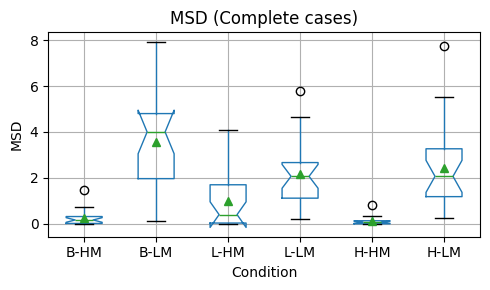

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
ptest.boxplot([1,2,3,4,5,6], showmeans = True, notch = True, ax=ax0)#[0])
plt.title("MSD (Complete cases)")
ax0.set_xticklabels(["B-HM", "B-LM", "L-HM", "L-LM","H-HM", "H-LM"])

ax0.set_ylabel('MSD')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig('pngs/msd-complete.png')

plt.show()

In [19]:
statprint(ptest, [1,2,3,4,5,6])

C Mean Std
1 0.255 0.342
2 3.573 2.134
3 0.979 1.21
4 2.161 1.435
5 0.13 0.187
6 2.452 1.84
-----------
FRIEDMAN 74.54, p=0.0
-----------
Wilcoxon (1, 2): Z=-4.015, p=0.0 *
Wilcoxon (1, 3): Z=-3.039, p=0.002 *
Wilcoxon (1, 4): Z=-4.015, p=0.0 *
Wilcoxon (1, 5): Z=-1.833, p=0.067
Wilcoxon (1, 6): Z=-4.107, p=0.0 *
Wilcoxon (2, 3): Z=-3.737, p=0.0 *
T-test (2, 4): t=3.488, p=0.002 *
Wilcoxon (2, 5): Z=-4.075, p=0.0 *
Wilcoxon (2, 6): Z=-2.029, p=0.042
Wilcoxon (3, 4): Z=-3.036, p=0.002 *
Wilcoxon (3, 5): Z=-3.552, p=0.0 *
Wilcoxon (3, 6): Z=-3.75, p=0.0 *
Wilcoxon (4, 5): Z=-4.015, p=0.0 *
Wilcoxon (4, 6): Z=-0.714, p=0.475
Wilcoxon (5, 6): Z=-4.108, p=0.0 *
bf-adj p: 0.0033

                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
                


In [20]:
##### Backspace count #####

In [21]:
events.head(2)

,id,pid,phrase,event,data,itype,ts,extype,effect,tsunix
0,27788,id9b42b4c9072cd8,"Target customers: Munis, Wapa, BPA.",KP,T,insertText,2024-08-06 20:10:08.947,2,1,1.722964e+09
1,27789,id9b42b4c9072cd8,"Target customers: Munis, Wapa, BPA.",KP,a,insertText,2024-08-06 20:10:12.573,2,1,1.722964e+09


In [22]:
events.groupby('itype').count()

,id,pid,phrase,event,data,ts,extype,effect,tsunix
itype,,,,,,,,,
deleteContentBackward,4423,4423,4423,4423,0,4423,4423,4423,4423
insertCompositionText,11427,11427,11427,11427,11349,11427,11427,11427,11427
insertReplacementText,107,107,107,107,107,107,107,107,107
insertText,56658,56658,56658,56658,56658,56658,56658,56658,56658


In [23]:
etest = events[events['itype']=='deleteContentBackward'][['pid','extype','id']].groupby(['pid', 'extype']).count()
etest.reset_index(inplace=True)
etest.head(5)

,pid,extype,id
0,571d293628d2680011ab9896,1,15
1,571d293628d2680011ab9896,2,30
2,571d293628d2680011ab9896,3,22
3,571d293628d2680011ab9896,4,22
4,571d293628d2680011ab9896,5,44


In [24]:
etest=etest.pivot(index='pid', columns ='extype', values='id')
etest.fillna(0, inplace=True)
etest.reset_index(inplace=True)
etest

extype,pid,1,2,3,4,5,6
0,571d293628d2680011ab9896,15.0,30.0,22.0,22.0,44.0,30.0
1,57cc61d2f734660001106261,42.0,41.0,36.0,74.0,28.0,75.0
2,5966f6c744b2d20001defeec,18.0,53.0,22.0,36.0,27.0,38.0
3,5ab15ab4c42b630001cd36fb,3.0,10.0,2.0,17.0,13.0,14.0
4,5bb2a0148f3bd70001e5633f,6.0,21.0,17.0,41.0,13.0,25.0
5,5c0ae93ec1a5a60001a560b6,57.0,66.0,94.0,89.0,36.0,122.0
6,5e8a5a892f6f027054a83d88,43.0,75.0,17.0,57.0,17.0,60.0
7,5e8e38da572c650e2ede51c9,37.0,83.0,91.0,54.0,21.0,43.0
8,5f00fa2353b5c10c934298fa,69.0,41.0,35.0,78.0,19.0,73.0
9,5f3d63a8d956100fd3adf56d,5.0,13.0,20.0,15.0,4.0,21.0


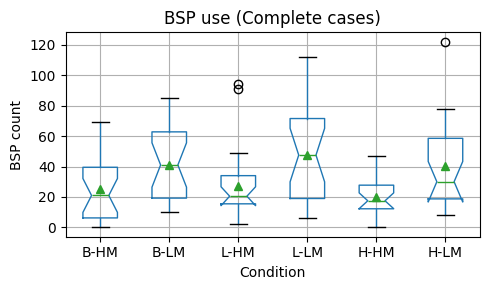

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
etest.boxplot([1,2,3,4,5,6], showmeans = True, notch = True, ax=ax0)#[0])
plt.title("BSP use (Complete cases)")
ax0.set_xticklabels(["B-HM", "B-LM", "L-HM", "L-LM","H-HM", "H-LM"])

ax0.set_ylabel('BSP count')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig('pngs/bsp-complete.png')

plt.show()

In [27]:
statprint(etest, [1,2,3,4,5,6])

C Mean Std
1 25.0 19.354
2 41.182 24.643
3 27.5 24.089
4 47.455 31.294
5 19.773 13.165
6 40.136 28.674
-----------
FRIEDMAN 39.316, p=0.0
-----------
T-test (1, 2): t=-3.564, p=0.002 *
Wilcoxon (1, 3): Z=-0.844, p=0.398
T-test (1, 4): t=-5.276, p=0.0 *
T-test (1, 5): t=1.375, p=0.184
Wilcoxon (1, 6): Z=-3.345, p=0.001 *
Wilcoxon (2, 3): Z=-2.81, p=0.005
T-test (2, 4): t=-1.265, p=0.22
T-test (2, 5): t=4.351, p=0.0 *
Wilcoxon (2, 6): Z=-0.4, p=0.689
Wilcoxon (3, 4): Z=-3.027, p=0.002 *
Wilcoxon (3, 5): Z=-1.419, p=0.156
Wilcoxon (3, 6): Z=-2.835, p=0.005
T-test (4, 5): t=4.689, p=0.0 *
Wilcoxon (4, 6): Z=-1.606, p=0.108
Wilcoxon (5, 6): Z=-3.076, p=0.002 *
bf-adj p: 0.0033

                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
                


In [28]:
##### WPM test ######


In [29]:
events.head(3)

,id,pid,phrase,event,data,itype,ts,extype,effect,tsunix
0,27788,id9b42b4c9072cd8,"Target customers: Munis, Wapa, BPA.",KP,T,insertText,2024-08-06 20:10:08.947,2,1,1.722964e+09
1,27789,id9b42b4c9072cd8,"Target customers: Munis, Wapa, BPA.",KP,a,insertText,2024-08-06 20:10:12.573,2,1,1.722964e+09
2,27790,id9b42b4c9072cd8,"Target customers: Munis, Wapa, BPA.",KP,r,insertText,2024-08-06 20:10:12.839,2,1,1.722964e+09


In [30]:
evmin = events[['pid','extype','phrase', 'ts', 'tsunix']].groupby(['pid','extype','phrase']).min()
evmin.reset_index(inplace=True)
evmin.head(5)

,pid,extype,phrase,ts,tsunix
0,571d293628d2680011ab9896,1,Are you getting all the information you need?,2024-08-11 11:22:51.659,1.723365e+09
1,571d293628d2680011ab9896,1,Don't they have some conflicts here?,2024-08-11 11:24:24.378,1.723365e+09
2,571d293628d2680011ab9896,1,Have I mentioned how much I love Houston traffic?,2024-08-11 11:23:55.997,1.723365e+09
3,571d293628d2680011ab9896,1,I am not concerned with the Brown money.,2024-08-11 11:23:19.008,1.723365e+09
4,571d293628d2680011ab9896,1,I am now officially a Blackberry addict.,2024-08-11 11:23:36.781,1.723365e+09


In [31]:
evmax = events[['pid','extype','phrase', 'ts', 'tsunix']].groupby(['pid','extype','phrase']).max()
evmax.reset_index(inplace=True)
evmax.head(5)

,pid,extype,phrase,ts,tsunix
0,571d293628d2680011ab9896,1,Are you getting all the information you need?,2024-08-11 11:23:00.828,1.723365e+09
1,571d293628d2680011ab9896,1,Don't they have some conflicts here?,2024-08-11 11:24:35.407,1.723365e+09
2,571d293628d2680011ab9896,1,Have I mentioned how much I love Houston traffic?,2024-08-11 11:24:13.890,1.723365e+09
3,571d293628d2680011ab9896,1,I am not concerned with the Brown money.,2024-08-11 11:23:28.694,1.723365e+09
4,571d293628d2680011ab9896,1,I am now officially a Blackberry addict.,2024-08-11 11:23:46.534,1.723365e+09


In [32]:
evjoin = evmin.set_index(['pid','extype','phrase']).join(evmax.set_index(['pid','extype','phrase']), lsuffix='_min', rsuffix='_max')
evjoin.reset_index(inplace=True)
evjoin['diff'] = evjoin['tsunix_max']-evjoin['tsunix_min']
evjoin.rename(columns={"phrase": "orig_phrase"}, inplace=True)
evjoin.head(5)

,pid,extype,orig_phrase,ts_min,tsunix_min,ts_max,tsunix_max,diff
0,571d293628d2680011ab9896,1,Are you getting all the information you need?,2024-08-11 11:22:51.659,1.723365e+09,2024-08-11 11:23:00.828,1.723365e+09,9.169
1,571d293628d2680011ab9896,1,Don't they have some conflicts here?,2024-08-11 11:24:24.378,1.723365e+09,2024-08-11 11:24:35.407,1.723365e+09,11.029
2,571d293628d2680011ab9896,1,Have I mentioned how much I love Houston traffic?,2024-08-11 11:23:55.997,1.723365e+09,2024-08-11 11:24:13.890,1.723365e+09,17.893
3,571d293628d2680011ab9896,1,I am not concerned with the Brown money.,2024-08-11 11:23:19.008,1.723365e+09,2024-08-11 11:23:28.694,1.723365e+09,9.686
4,571d293628d2680011ab9896,1,I am now officially a Blackberry addict.,2024-08-11 11:23:36.781,1.723365e+09,2024-08-11 11:23:46.534,1.723365e+09,9.753


In [33]:
phrases.head(5)

,id,pid,extype,orig_phrase,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist
0,721,id9b42b4c9072cd8,2,"Target customers: Munis, Wapa, BPA.","Target customers: Munis, Wapa, BPA.",1,target customers munis wapa bpa,target customers munis wapa bpa,0
1,722,id9b42b4c9072cd8,2,Thanks - that's what I was hoping it was.,Thanks - that's what i was hoping it was.,1,thanks thats what i was hoping it was,thanks thats what i was hoping it was,0
2,723,id9b42b4c9072cd8,2,Can I meet with you at 4:00?,Can i meet with you at 4:00?,1,can i meet with you at 400,can i meet with you at 400,0
3,724,id9b42b4c9072cd8,2,That's not the behavior that I was looking for.,That's not the bahavior that i was looking for.,1,thats not the behavior that i was looking for,thats not the bahavior that i was looking for,1
4,725,id9b42b4c9072cd8,2,"If this has already been covered, then I apolo...","If this has already been covered, then i apolo...",1,if this has already been covered then i apologize,if this has already been covered then i apologize,0


In [34]:
evjoin = phrases.set_index(['pid','extype','orig_phrase']).join(evjoin.set_index(['pid','extype','orig_phrase']))
evjoin.reset_index(inplace=True)
evjoin.head(5)

,pid,extype,orig_phrase,id,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist,ts_min,tsunix_min,ts_max,tsunix_max,diff
0,id9b42b4c9072cd8,2,"Target customers: Munis, Wapa, BPA.",721,"Target customers: Munis, Wapa, BPA.",1,target customers munis wapa bpa,target customers munis wapa bpa,0,2024-08-06 20:10:08.947,1.722964e+09,2024-08-06 20:10:36.045,1.722964e+09,27.098
1,id9b42b4c9072cd8,2,Thanks - that's what I was hoping it was.,722,Thanks - that's what i was hoping it was.,1,thanks thats what i was hoping it was,thanks thats what i was hoping it was,0,2024-08-06 20:10:53.529,1.722964e+09,2024-08-06 20:11:16.449,1.722964e+09,22.920
2,id9b42b4c9072cd8,2,Can I meet with you at 4:00?,723,Can i meet with you at 4:00?,1,can i meet with you at 400,can i meet with you at 400,0,2024-08-06 20:11:32.840,1.722964e+09,2024-08-06 20:11:44.128,1.722964e+09,11.288
3,id9b42b4c9072cd8,2,That's not the behavior that I was looking for.,724,That's not the bahavior that i was looking for.,1,thats not the behavior that i was looking for,thats not the bahavior that i was looking for,1,2024-08-06 20:12:01.557,1.722964e+09,2024-08-06 20:12:25.221,1.722964e+09,23.664
4,id9b42b4c9072cd8,2,"If this has already been covered, then I apolo...",725,"If this has already been covered, then i apolo...",1,if this has already been covered then i apologize,if this has already been covered then i apologize,0,2024-08-06 20:12:38.850,1.722964e+09,2024-08-06 20:12:59.625,1.722964e+09,20.775


In [35]:
def wpms(xid, string, time):
    try:
        return (len(string) / 5) / (time/60)
    except:
        print(xid, string)

evjoin['wpm']=evjoin.apply(lambda x: wpms(x.name, x['sub_phrase'], x['diff']), axis=1)
evjoin.head(5)

390 nan


,pid,extype,orig_phrase,id,sub_phrase,effect,orig_clean,sub_phrase_clean,ldist,ts_min,tsunix_min,ts_max,tsunix_max,diff,wpm
0,id9b42b4c9072cd8,2,"Target customers: Munis, Wapa, BPA.",721,"Target customers: Munis, Wapa, BPA.",1,target customers munis wapa bpa,target customers munis wapa bpa,0,2024-08-06 20:10:08.947,1.722964e+09,2024-08-06 20:10:36.045,1.722964e+09,27.098,15.942136
1,id9b42b4c9072cd8,2,Thanks - that's what I was hoping it was.,722,Thanks - that's what i was hoping it was.,1,thanks thats what i was hoping it was,thanks thats what i was hoping it was,0,2024-08-06 20:10:53.529,1.722964e+09,2024-08-06 20:11:16.449,1.722964e+09,22.920,21.989529
2,id9b42b4c9072cd8,2,Can I meet with you at 4:00?,723,Can i meet with you at 4:00?,1,can i meet with you at 400,can i meet with you at 400,0,2024-08-06 20:11:32.840,1.722964e+09,2024-08-06 20:11:44.128,1.722964e+09,11.288,29.766123
3,id9b42b4c9072cd8,2,That's not the behavior that I was looking for.,724,That's not the bahavior that i was looking for.,1,thats not the behavior that i was looking for,thats not the bahavior that i was looking for,1,2024-08-06 20:12:01.557,1.722964e+09,2024-08-06 20:12:25.221,1.722964e+09,23.664,24.340771
4,id9b42b4c9072cd8,2,"If this has already been covered, then I apolo...",725,"If this has already been covered, then i apolo...",1,if this has already been covered then i apologize,if this has already been covered then i apologize,0,2024-08-06 20:12:38.850,1.722964e+09,2024-08-06 20:12:59.625,1.722964e+09,20.775,30.036101


In [36]:
evjoin = evjoin[['pid','extype','wpm']].groupby(['pid','extype']).mean()
evjoin.reset_index(inplace=True)
evjoin.head(5)
#ptest.pivot(index='pid', columns ='extype', values='ldist')

,pid,extype,wpm
0,571d293628d2680011ab9896,1,49.404034
1,571d293628d2680011ab9896,2,26.561012
2,571d293628d2680011ab9896,3,39.185326
3,571d293628d2680011ab9896,4,31.648648
4,571d293628d2680011ab9896,5,46.297003


In [37]:
evjoin=evjoin.pivot(index='pid', columns ='extype', values='wpm')
evjoin.reset_index(inplace=True)
evjoin.head(5)

extype,pid,1,2,3,4,5,6
0,571d293628d2680011ab9896,49.404034,26.561012,39.185326,31.648648,46.297003,33.585053
1,57cc61d2f734660001106261,70.525376,66.634031,83.378099,70.509187,74.594122,65.103151
2,5966f6c744b2d20001defeec,58.144365,43.399394,55.075035,45.806995,52.104967,47.825462
3,5ab15ab4c42b630001cd36fb,32.743958,25.778276,34.422960,25.584881,30.869318,21.886299
4,5bb2a0148f3bd70001e5633f,43.465657,31.589824,38.980266,27.068487,45.980557,28.832293


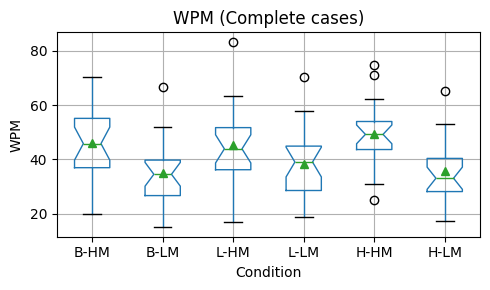

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
#ax0, ax1, ax2, ax3 = axes.flatten()
ax0=axes
evjoin.boxplot([1,2,3,4,5,6], showmeans = True, notch = True, ax=ax0)#[0])
plt.title("WPM (Complete cases)")
ax0.set_xticklabels(["B-HM", "B-LM", "L-HM", "L-LM","H-HM", "H-LM"])

ax0.set_ylabel('WPM')
ax0.set_xlabel('Condition')
plt.tight_layout()
plt.savefig('pngs/wpm-complete.png')

plt.show()

In [39]:
statprint(evjoin, [1,2,3,4,5,6])

C Mean Std
1 46.044 12.832
2 35.024 11.013
3 45.359 14.09
4 38.222 11.825
5 49.269 11.896
6 35.883 11.292
-----------
FRIEDMAN 78.519, p=0.0
-----------
Wilcoxon (1, 2): Z=-3.717, p=0.0 *
T-test (1, 3): t=0.577, p=0.57
T-test (1, 4): t=5.197, p=0.0 *
T-test (1, 5): t=-2.668, p=0.014
T-test (1, 6): t=6.972, p=0.0 *
Wilcoxon (2, 3): Z=-4.074, p=0.0 *
Wilcoxon (2, 4): Z=-2.841, p=0.005
Wilcoxon (2, 5): Z=-4.074, p=0.0 *
Wilcoxon (2, 6): Z=-1.088, p=0.277
T-test (3, 4): t=5.917, p=0.0 *
T-test (3, 5): t=-3.412, p=0.003 *
T-test (3, 6): t=8.681, p=0.0 *
T-test (4, 5): t=-9.486, p=0.0 *
T-test (4, 6): t=2.235, p=0.036
T-test (5, 6): t=11.354, p=0.0 *
bf-adj p: 0.0033

                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
                


In [40]:
# Questionnaires

In [41]:
qdf = pd.read_csv('questionnaires-partial.csv')
qdf.head(2)

,id,ts,pid,q1,q2,q3,q4,q5,q6,q7,...,q13,q14,q15,q16,q17,q18,q19,q20,extype,start_time
0,6,2024-08-05 14:07:11.025,id29559f3e7b829,4,4,4,4,4,3,3,...,3,2,2,2,NaN,NaN,NaN,NaN,3,2024-08-05 14:05:42.801
1,7,2024-08-05 14:13:06.998,id29559f3e7b829,4,4,4,4,4,3,4,...,3,3,2,2,NaN,NaN,NaN,NaN,5,2024-08-05 14:11:31.216


In [42]:
qtest = qdf[['pid','extype','q1','q2','q3','q4','q5','q6','q7', 'q8','q9','q10','q11','q12','q13','q14','q15','q16']].groupby(['pid','extype']).mean()
qtest.reset_index(inplace=True)
qtest.head(5)

,pid,extype,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16
0,571d293628d2680011ab9896,1,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,3.0,4.0,3.0,3.0,2.0
1,571d293628d2680011ab9896,2,5.0,5.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,2.0
2,571d293628d2680011ab9896,3,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0
3,571d293628d2680011ab9896,4,4.0,5.0,2.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,3.0,2.0
4,571d293628d2680011ab9896,5,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0


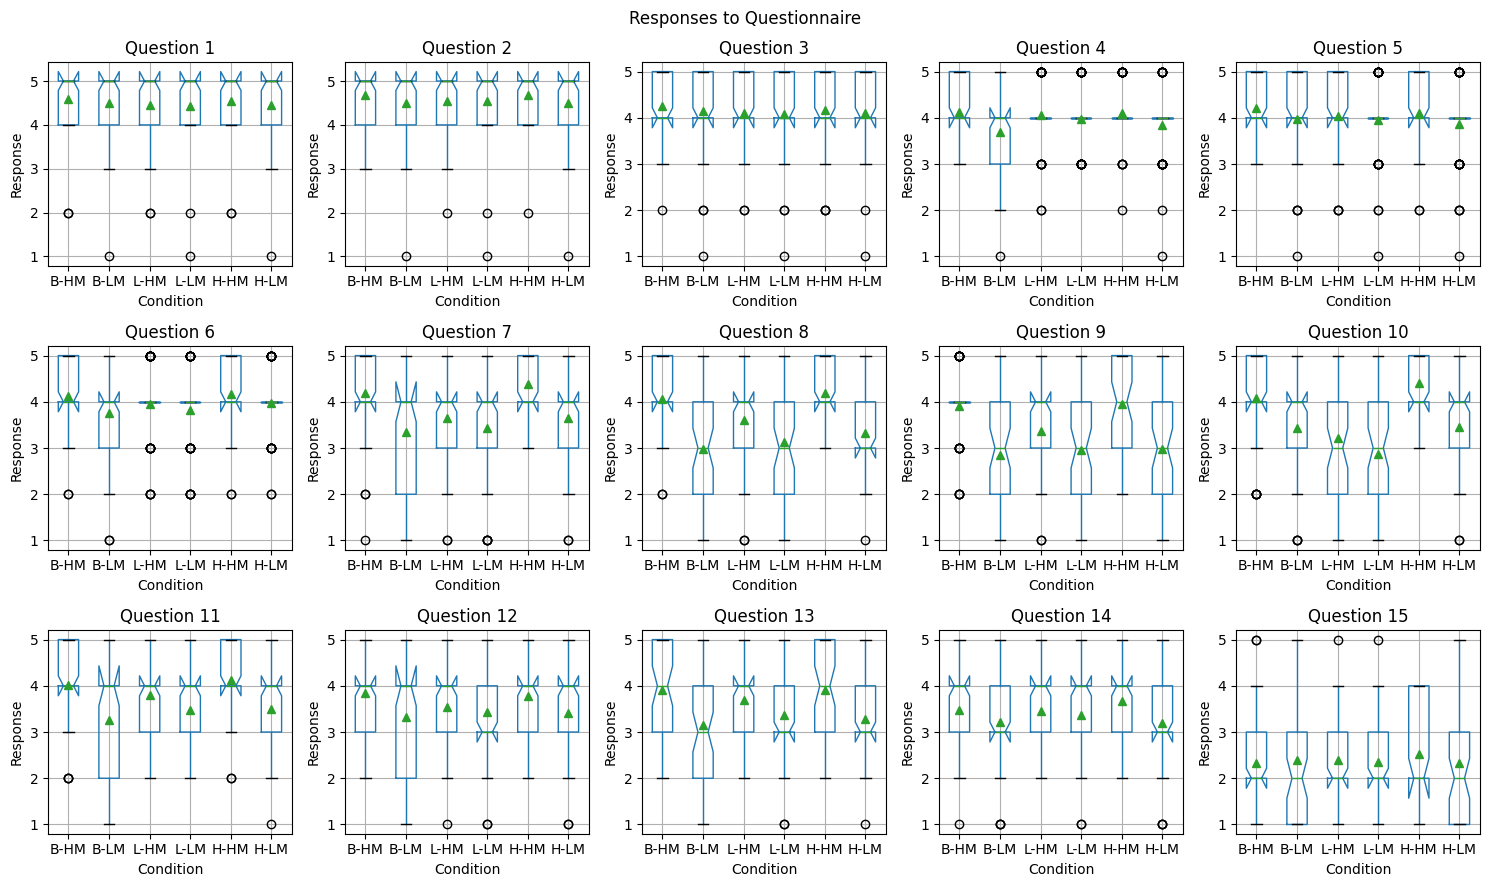

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
#ax0, ax1, ax2, ax3 = axes.flatten()
question=1
for i in range(0,3):
    for j in range(0,5):
        qtest[['extype','q'+str(question)]].boxplot(by='extype', showmeans = True, notch = True, ax=axes[i][j])
        axes[i][j].set_title("Question "+str(question))
        axes[i][j].set_ylabel("Response")
        axes[i][j].set_xlabel("Condition")
        axes[i][j].set_xticklabels(["B-HM", "B-LM", "L-HM", "L-LM","H-HM", "H-LM"])

        question+=1
fig.suptitle("Responses to Questionnaire")
plt.tight_layout()
plt.savefig('pngs/q-all.png')

plt.show()

In [47]:
## 1-5 = Task engagement
## 6-10 = Task realism
## 11-15 = Emotional engagement

In [48]:
for i in range (1, 16):
    qtest_stat = qtest[['pid','extype','q'+str(i)]]
    qtest_stat=qtest_stat.pivot(index='pid', columns ='extype', values='q'+str(i))
    qtest_stat.reset_index(inplace=True)
    print("Question "+str(i))
    statprint(qtest_stat, [1,2,3,4,5,6])
    print("------")


Question 1
C Mean Std
1 4.585 0.692
2 4.509 0.724
3 4.453 0.748
4 4.434 0.772
5 4.547 0.695
6 4.453 0.722
-----------
FRIEDMAN 7.827, p=0.166
-----------
------
Question 2
C Mean Std
1 4.679 0.547
2 4.491 0.724
3 4.547 0.667
4 4.547 0.774
5 4.679 0.581
6 4.491 0.75
-----------
FRIEDMAN 14.126, p=0.015
-----------
Wilcoxon (1, 2): Z=-2.673, p=0.008
Wilcoxon (1, 3): Z=-1.941, p=0.052
Wilcoxon (1, 4): Z=-1.807, p=0.071
Wilcoxon (1, 5): Z=-0.0, p=1.0
Wilcoxon (1, 6): Z=-2.5, p=0.012
Wilcoxon (2, 3): Z=-0.646, p=0.518
Wilcoxon (2, 4): Z=-1.0, p=0.317
Wilcoxon (2, 5): Z=-2.324, p=0.02
Wilcoxon (2, 6): Z=-0.0, p=1.0
Wilcoxon (3, 4): Z=-0.0, p=1.0
Wilcoxon (3, 5): Z=-2.111, p=0.035
Wilcoxon (3, 6): Z=-0.676, p=0.499
Wilcoxon (4, 5): Z=-1.897, p=0.058
Wilcoxon (4, 6): Z=-1.134, p=0.257
Wilcoxon (5, 6): Z=-2.178, p=0.029
bf-adj p: 0.0033

                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context -

In [49]:
qs = []
for i in range (1,6):
    qs.append("q"+str(i))

print(['pid','extype']+qs)
              
qtest2=qtest[['pid','extype']+qs]
qtest2[['extype']+qs].groupby('extype').mean().reset_index()


['pid', 'extype', 'q1', 'q2', 'q3', 'q4', 'q5']


,extype,q1,q2,q3,q4,q5
0,1,4.584906,4.679245,4.245283,4.132075,4.207547
1,2,4.509434,4.490566,4.150943,3.698113,3.981132
2,3,4.452830,4.547170,4.113208,4.056604,4.037736
3,4,4.433962,4.547170,4.075472,3.981132,3.943396
4,5,4.547170,4.679245,4.169811,4.094340,4.113208
5,6,4.452830,4.490566,4.094340,3.849057,3.867925


In [50]:
qs = []
for i in range (6,11):
    qs.append("q"+str(i))

print(['pid','extype']+qs)
              
qtest2=qtest[['pid','extype']+qs]
qtest2[['extype']+qs].groupby('extype').mean().reset_index()


['pid', 'extype', 'q6', 'q7', 'q8', 'q9', 'q10']


,extype,q6,q7,q8,q9,q10
0,1,4.132075,4.188679,4.056604,3.905660,4.075472
1,2,3.754717,3.339623,2.981132,2.849057,3.433962
2,3,3.962264,3.660377,3.603774,3.377358,3.207547
3,4,3.830189,3.433962,3.132075,2.962264,2.867925
4,5,4.169811,4.377358,4.188679,3.962264,4.396226
5,6,3.981132,3.660377,3.320755,2.981132,3.452830


In [51]:
qs = []
for i in range (11,16):
    qs.append("q"+str(i))

print(['pid','extype']+qs)
              
qtest2=qtest[['pid','extype']+qs]
qtest2[['extype']+qs].groupby('extype').mean().reset_index()

['pid', 'extype', 'q11', 'q12', 'q13', 'q14', 'q15']


,extype,q11,q12,q13,q14,q15
0,1,4.018868,3.849057,3.905660,3.471698,2.320755
1,2,3.264151,3.320755,3.150943,3.207547,2.396226
2,3,3.811321,3.547170,3.698113,3.452830,2.396226
3,4,3.471698,3.433962,3.358491,3.358491,2.358491
4,5,4.132075,3.773585,3.905660,3.679245,2.528302
5,6,3.490566,3.415094,3.283019,3.188679,2.339623


In [ ]:
'''
                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
'''

In [ ]:
### factor analysis

In [54]:
# Load data
#data = qtest[qtest['extype']==1].drop(['pid', 'extype', 'q16'],axis=1)
data = qtest.drop(['pid', 'extype', 'q16'],axis=1)
data.dropna(inplace=True)

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   q1      318 non-null    float64
 1   q2      318 non-null    float64
 2   q3      318 non-null    float64
 3   q4      318 non-null    float64
 4   q5      318 non-null    float64
 5   q6      318 non-null    float64
 6   q7      318 non-null    float64
 7   q8      318 non-null    float64
 8   q9      318 non-null    float64
 9   q10     318 non-null    float64
 10  q11     318 non-null    float64
 11  q12     318 non-null    float64
 12  q13     318 non-null    float64
 13  q14     318 non-null    float64
 14  q15     318 non-null    float64
dtypes: float64(15)
memory usage: 37.4 KB


In [55]:

# Apply Bartlett's test
chi_square_value, p_value = calculate_bartlett_sphericity(data)
print(f'Chi-square value: {chi_square_value}\nP-value: {p_value}')



Chi-square value: 3126.505151777548
P-value: 0.0


In [56]:
# Apply KMO test
kmo_all, kmo_model = calculate_kmo(data)
print(f'KMO Model: {kmo_model}')



KMO Model: 0.8955378293149354


Factors 3


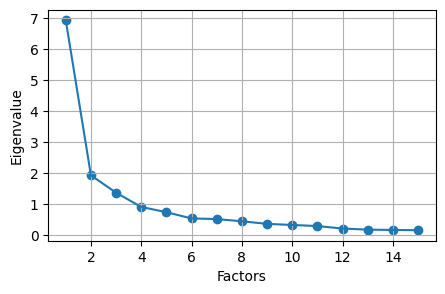

[[-0.12763415 -0.03424358  0.9789963 ]
 [-0.0788487  -0.03233897  0.95573667]
 [ 0.17683007  0.01149832  0.53913324]
 [ 0.40123075  0.10699742  0.28817664]
 [ 0.45966578 -0.00886837  0.39982604]
 [ 0.0286693   0.5795797   0.2011555 ]
 [-0.11223429  0.85634909  0.04946974]
 [ 0.10968752  0.88091819 -0.16725318]
 [ 0.16116209  0.80357772 -0.18788828]
 [-0.1417271   0.73828356  0.09758727]
 [ 0.82119033  0.13411976 -0.03943966]
 [ 1.05729621 -0.11044304 -0.16541909]
 [ 0.86951672  0.10935593 -0.12306585]
 [ 0.6717955  -0.04438736  0.1068611 ]
 [ 0.36906662 -0.03314298  0.03106648]]
-----
(array([3.63337234, 3.09515395, 2.57759591]), array([0.24222482, 0.2063436 , 0.17183973]), array([0.24222482, 0.44856842, 0.62040815]))
-----
[[-3.20273743e-02  5.95687235e-01  4.75857607e-01]
 [ 2.78370990e-01 -7.87016664e-01  4.56309147e-01]
 [ 1.89941561e-01  3.57272952e-01 -7.34046425e-01]
 [-2.85987559e-02 -6.14648557e-01 -2.56576542e-01]
 [ 5.06417432e-01  4.20095126e-01  6.13384905e-01]
 [ 3.228559

In [60]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation="promax")
fa.fit(data)

# Check Eigenvalues
eigen_values, vectors = fa.get_eigenvalues()
nfactors=0
for ev in eigen_values:
    if ev>=1:
        nfactors+=1
print("Factors", nfactors)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
ax = axes
ax.scatter(range(1, data.shape[1]+1), eigen_values)
ax.plot(range(1, data.shape[1]+1), eigen_values)
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.savefig('pngs/scree.png')
plt.show()

# Perform factor analysis with the determined number of factors
fa = FactorAnalyzer(n_factors=nfactors, rotation="promax")
fa.fit(data)

# Get factor loadings
loadings = fa.loadings_
print(loadings)
print('-----')

# Get variance of each factor
print(fa.get_factor_variance())
print('-----')
# Get factor scores
factor_scores = fa.transform(data)
print(factor_scores)

In [61]:
print(qtest.columns)
loadings = pd.DataFrame(loadings, columns=['Factor 1', 'Factor 2', 'Factor 3'], index=qtest.columns[2:17])
print('Factor Loadings \n%s' %loadings)

Index(['pid', 'extype', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
       'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16'],
      dtype='object')
Factor Loadings 
     Factor 1  Factor 2  Factor 3
q1  -0.127634 -0.034244  0.978996
q2  -0.078849 -0.032339  0.955737
q3   0.176830  0.011498  0.539133
q4   0.401231  0.106997  0.288177
q5   0.459666 -0.008868  0.399826
q6   0.028669  0.579580  0.201155
q7  -0.112234  0.856349  0.049470
q8   0.109688  0.880918 -0.167253
q9   0.161162  0.803578 -0.187888
q10 -0.141727  0.738284  0.097587
q11  0.821190  0.134120 -0.039440
q12  1.057296 -0.110443 -0.165419
q13  0.869517  0.109356 -0.123066
q14  0.671795 -0.044387  0.106861
q15  0.369067 -0.033143  0.031066


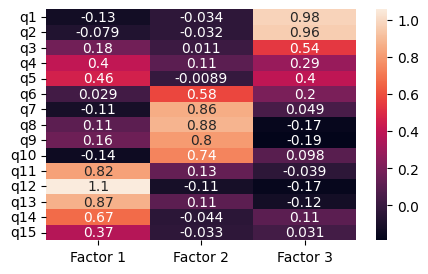

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
ax = axes
ax = sns.heatmap(loadings, annot=True, cmap='rocket', ax=ax)
ax.set_xticklabels(["Factor 1", "Factor 2", "Factor 3"])
ax.set_yticklabels(loadings.index)
plt.savefig('pngs/loadings.png')
plt.show()

In [63]:
#Factor 1 = emotional engagement
#Factor 2 = task realism
#Factor 3 = task engagement

In [64]:
data2 = pd.DataFrame(factor_scores, columns=['Factor 1', 'Factor 2', 'Factor 3'], index=qtest['pid'])
data2['extype'] = list(qtest['extype'])
data2.index.rename('idx', inplace=True)
data2['pid'] = data2.index
data2.reset_index(inplace=True)
data2.drop('idx', axis=1, inplace=True)
data2

,Factor 1,Factor 2,Factor 3,extype,pid
0,-0.032027,0.595687,0.475858,1,571d293628d2680011ab9896
1,0.278371,-0.787017,0.456309,2,571d293628d2680011ab9896
2,0.189942,0.357273,-0.734046,3,571d293628d2680011ab9896
3,-0.028599,-0.614649,-0.256577,4,571d293628d2680011ab9896
4,0.506417,0.420095,0.613385,5,571d293628d2680011ab9896
...,...,...,...,...,...
313,-1.532112,-2.849530,-0.806777,2,idee6df4f18551
314,0.391722,-1.468645,0.433820,3,idee6df4f18551
315,-0.297355,-2.557210,-0.624247,4,idee6df4f18551
316,0.289393,0.302578,0.582287,5,idee6df4f18551


In [65]:
len(factor_scores)

318

In [66]:
for i in range (1, 4):
    qtest_stat2 = data2[['pid','extype','Factor '+str(i)]]
    qtest_stat2=qtest_stat2.pivot(index='pid', columns ='extype', values='Factor '+str(i))
    qtest_stat2.reset_index(inplace=True)
    print("Factor "+str(i))
    statprint(qtest_stat2, [1,2,3,4,5,6])
    print("------")

Factor 1
C Mean Std
1 0.329 0.854
2 -0.34 1.131
3 0.071 0.858
4 -0.168 0.891
5 0.333 0.86
6 -0.225 1.009
-----------
ANOVA 5.035, p=0.0
-----------
T-test (1, 2): t=5.691, p=0.0 *
T-test (1, 3): t=4.361, p=0.0 *
T-test (1, 4): t=6.878, p=0.0 *
T-test (1, 5): t=-0.063, p=0.95
T-test (1, 6): t=5.223, p=0.0 *
T-test (2, 3): t=-3.701, p=0.001 *
T-test (2, 4): t=-1.728, p=0.09
T-test (2, 5): t=-4.974, p=0.0 *
T-test (2, 6): t=-0.999, p=0.322
T-test (3, 4): t=3.202, p=0.002 *
T-test (3, 5): t=-3.32, p=0.002 *
T-test (3, 6): t=2.738, p=0.008
T-test (4, 5): t=-5.563, p=0.0 *
T-test (4, 6): t=0.606, p=0.547
T-test (5, 6): t=5.781, p=0.0 *
bf-adj p: 0.0033

                1 - no context - high mem
                2 - no context - low mem
                3 - llm-context - high mem
                4 - llm-context - low mem
                5 - human-context - high mem
                6 - human-context - low mem
                
------
Factor 2
C Mean Std
1 0.488 0.734
2 -0.475 1.112
3 -0.035 0.884

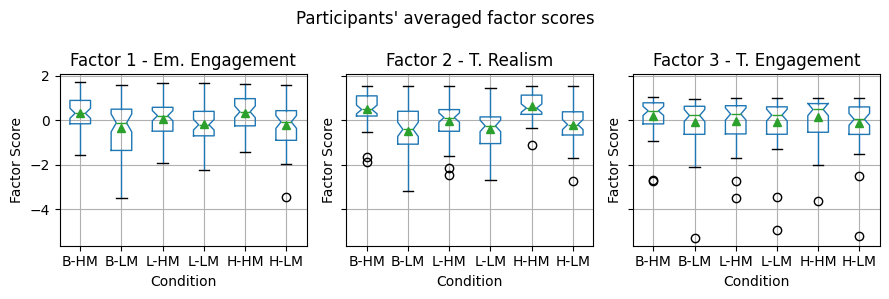

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharey=True)
#ax0, ax1, ax2, ax3 = axes.flatten()
question=1
for i in range(0,3):
        data2[['extype','Factor '+str(question)]].boxplot(by='extype', showmeans = True, notch = True, ax=axes[i])
        axes[i].set_ylabel("Factor Score")
        axes[i].set_xlabel("Condition")
        axes[i].set_xticklabels(["B-HM", "B-LM", "L-HM", "L-LM","H-HM", "H-LM"])

        question+=1
fig.suptitle("Participants' averaged factor scores")
axes[0].set_title("Factor 1 - Em. Engagement")
axes[1].set_title("Factor 2 - T. Realism")
axes[2].set_title("Factor 3 - T. Engagement")

plt.tight_layout()
plt.savefig('pngs/q-factored.png')

plt.show()